In [1]:
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import climate, massbalance, flowline
from oggm.shop import gcm_climate, bedtopo

import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import os 

# oggm initialzation
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing']=True
cfg.PATHS['working_dir'] = '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['cfl_number'] = 0.02
#cfg.PARAMS['run_mb_calibration'] = True

2021-10-28 10:06:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-10-28 10:06:49: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-10-28 10:06:49: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-10-28 10:06:49: oggm.cfg: Multiprocessing switched ON after user settings.
2021-10-28 10:06:49: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


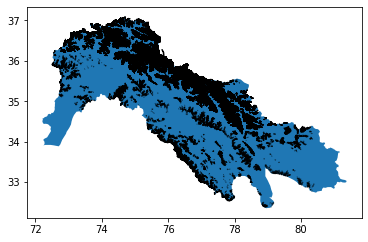

In [2]:
path_test='/home/lucillegimenes/shp_wr/Himalaya_WaterResources_20201006.shp'
basin = gpd.read_file(path_test)
basin=basin.loc[[3],:] #LaPaz 0 2020-10-05_ContourWaterResources.shp, Karakoram 3 Himalaya_WaterResources_20201006.shp

fr = utils.get_rgi_region_file(14) 
gdf = gpd.read_file(fr)

fr2 = utils.get_rgi_region_file(13) 
gdf2 = gpd.read_file(fr2)

gdf_tot=pd.concat([gdf,gdf2],axis=0)

import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[3] for
          (x, y) in zip(gdf_tot.CenLon, gdf_tot.CenLat)] #nb in brackets has to be the index in loc above

gdf_sel = gdf_tot.loc[in_bas]

ax=basin.plot()
gdf_sel.plot(ax=ax, edgecolor='k');


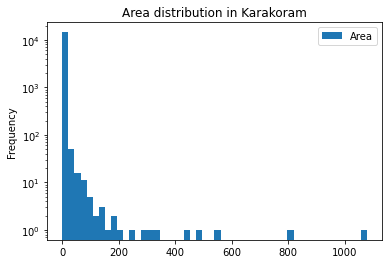

In [3]:
gdf_sel[['Area']].plot(kind='hist', bins=(50), logy=True);

plt.title('Area distribution in Karakoram')
name = 'histogram_area_Karakoram.png'
plt.savefig(name, format = 'png')

In [4]:
sel=gdf_sel["RGIId"]
rgi_ids=sel.values.tolist()

In [5]:
len(rgi_ids)

14529

In [13]:
smaller=gdf_sel.loc[gdf_sel['Area']<4,:]
bigger= gdf_sel.loc[(gdf_sel['Area']>=4) & (gdf_sel['RGIId']!='RGI60-14.05675') & (gdf_sel['RGIId']!='RGI60-14.04404')
                    & (gdf_sel['RGIId']!='RGI60-14.05749') & (gdf_sel['RGIId']!='RGI60-14.08485'),:]
sel=bigger["RGIId"]
rgi_ids=sel.values.tolist()

In [14]:
a_s=smaller[['Area']].sum(axis=0)[0]
a_b=bigger[['Area']].sum(axis=0)[0]
ratio_s=a_s/(gdf_sel[['Area']].sum(axis=0)[0])*100
ratio_b=a_b/(gdf_sel[['Area']].sum(axis=0)[0])*100

In [15]:
print(ratio_s,ratio_b)

30.939855756923745 67.84125580051857


In [5]:
#Pour Mont Blanc
rgi_ids.remove('RGI60-11.03008')
rgi_ids.remove('RGI60-11.03009')

In [ ]:
#Ajustement LaPaz
rgi_ids.remove('RGI60-16.00516')
rgi_ids.remove('RGI60-16.00558')
rgi_ids.remove('RGI60-16.00560')
rgi_ids.remove('RGI60-16.00569')

In [16]:
gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=2,prepro_rgi_version=62,prepro_border=80)


2021-10-28 10:41:07: oggm.workflow: init_glacier_directories from prepro level 2 on 645 glaciers.
2021-10-28 10:41:07: oggm.workflow: Execute entity task gdir_from_prepro on 645 glaciers


In [26]:
gtr=workflow.init_glacier_directories(['RGI60-14.04404'],from_prepro_level=2,prepro_rgi_version=62,prepro_border=80)

2021-10-28 12:28:49: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-10-28 12:28:49: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


In [19]:
#pre-processing tasks
prepro_task_list = [
        tasks.glacier_masks,  
        tasks.compute_centerlines,
        tasks.initialize_flowlines,
        tasks.compute_downstream_line,
        tasks.compute_downstream_bedshape,
        tasks.catchment_area,
        tasks.catchment_intersections,
        tasks.catchment_width_geom,
        tasks.catchment_width_correction   
        ]
for task in prepro_task_list:
    workflow.execute_entity_task(task, gdirs)

2021-10-28 11:03:48: oggm.workflow: Execute entity task glacier_masks on 645 glaciers
2021-10-28 11:05:25: oggm.workflow: Execute entity task compute_centerlines on 645 glaciers
2021-10-28 11:05:45: oggm.workflow: Execute entity task initialize_flowlines on 645 glaciers
2021-10-28 11:05:57: oggm.workflow: Execute entity task compute_downstream_line on 645 glaciers
2021-10-28 11:07:04: oggm.workflow: Execute entity task compute_downstream_bedshape on 645 glaciers
2021-10-28 11:09:08: oggm.workflow: Execute entity task catchment_area on 645 glaciers
2021-10-28 11:13:30: oggm.workflow: Execute entity task catchment_intersections on 645 glaciers
2021-10-28 11:14:46: oggm.workflow: Execute entity task catchment_width_geom on 645 glaciers
2021-10-28 11:22:42: oggm.workflow: Execute entity task catchment_width_correction on 645 glaciers


In [27]:
for task in prepro_task_list:
    workflow.execute_entity_task(task, gtr)

2021-10-28 12:28:52: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2021-10-28 12:28:53: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2021-10-28 12:28:53: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2021-10-28 12:28:53: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2021-10-28 12:28:53: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2021-10-28 12:28:54: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2021-10-28 12:28:56: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
2021-10-28 12:28:56: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2021-10-28 12:28:59: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers


In [21]:

for gdir in gdirs:
    tasks.process_climate_data(gdir)
params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=params_url)

climate_task_list = [
        tasks.local_t_star,     
        tasks.mu_star_calibration
        ]

for task in climate_task_list:
        workflow.execute_entity_task(task, gdirs)

2021-10-28 12:07:27: oggm.workflow: Execute entity task local_t_star on 645 glaciers
2021-10-28 12:07:42: oggm.workflow: Execute entity task mu_star_calibration on 645 glaciers


In [30]:
tasks.process_climate_data(gtr[0])
for task in climate_task_list:
    workflow.execute_entity_task(task, gtr)

2021-10-28 12:29:20: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2021-10-28 12:29:20: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [31]:
import write_to_shape 
#converting flowlines to shapefile 
for gdir in gdirs:
    path_to_shp='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/outflow.shp'
    write_to_shape.write_centerlines_to_shape_bis(gdir, path=path_to_shp,flowlines_output=True)
    sh = gpd.read_file(path_to_shp)



2021-10-28 12:29:45: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.00/RGI60-14.00005/outflow.shp ...
2021-10-28 12:29:45: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:45: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.00/RGI60-14.00032/outflow.shp ...
2021-10-28 12:29:45: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:29:46: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:46: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.00/RGI60-14.00617/outflow.shp ...
2021-10-28 12:29:46: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:29:47: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.00/RGI60-14.00952/outflow.shp ...
2021-10-28 12:29:47: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:47: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.00/RGI60-14.00973/outflow.shp ...
2021-10-28 12:29:47: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:29:48: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:48: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.01/RGI60-14.01291/outflow.shp ...
2021-10-28 12:29:48: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:29:49: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.01/RGI60-14.01548/outflow.shp ...
2021-10-28 12:29:49: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:49: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.01/RGI60-14.01549/outflow.shp ...
2021-10-28 12:29:49: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:29:50: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:50: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.01/RGI60-14.01709/outflow.shp ...
2021-10-28 12:29:50: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:29:52: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.01/RGI60-14.01960/outflow.shp ...
2021-10-28 12:29:52: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:52: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.01/RGI60-14.01964/outflow.shp ...
2021-10-28 12:29:52: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:29:53: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:53: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.02/RGI60-14.02180/outflow.shp ...
2021-10-28 12:29:53: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:29:54: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.02/RGI60-14.02343/outflow.shp ...
2021-10-28 12:29:54: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:54: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.02/RGI60-14.02357/outflow.shp ...
2021-10-28 12:29:54: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:29:55: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:55: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.02/RGI60-14.02458/outflow.shp ...
2021-10-28 12:29:55: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:29:57: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.02/RGI60-14.02740/outflow.shp ...
2021-10-28 12:29:57: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:57: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.02/RGI60-14.02764/outflow.shp ...
2021-10-28 12:29:57: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:29:59: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:29:59: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.03/RGI60-14.03123/outflow.shp ...
2021-10-28 12:29:59: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:01: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.03/RGI60-14.03672/outflow.shp ...
2021-10-28 12:30:01: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:01: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.03/RGI60-14.03683/outflow.shp ...
2021-10-28 12:30:01: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:02: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:02: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04120/outflow.shp ...
2021-10-28 12:30:02: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:03: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04477/outflow.shp ...
2021-10-28 12:30:03: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:03: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04498/outflow.shp ...
2021-10-28 12:30:03: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:05: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:05: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04643/outflow.shp ...
2021-10-28 12:30:05: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:07: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04863/outflow.shp ...
2021-10-28 12:30:07: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:07: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04868/outflow.shp ...
2021-10-28 12:30:07: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:08: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:08: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04975/outflow.shp ...
2021-10-28 12:30:08: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:10: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.05/RGI60-14.05331/outflow.shp ...
2021-10-28 12:30:10: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:10: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.05/RGI60-14.05429/outflow.shp ...
2021-10-28 12:30:10: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:11: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:11: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.05/RGI60-14.05684/outflow.shp ...
2021-10-28 12:30:11: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:12: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.05/RGI60-14.05802/outflow.shp ...
2021-10-28 12:30:12: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:12: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.05/RGI60-14.05810/outflow.shp ...
2021-10-28 12:30:12: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:14: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:14: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.06/RGI60-14.06963/outflow.shp ...
2021-10-28 12:30:14: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:15: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.07/RGI60-14.07253/outflow.shp ...
2021-10-28 12:30:15: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:16: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.07/RGI60-14.07297/outflow.shp ...
2021-10-28 12:30:16: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:17: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:17: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.07/RGI60-14.07575/outflow.shp ...
2021-10-28 12:30:17: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:19: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.07/RGI60-14.07769/outflow.shp ...
2021-10-28 12:30:19: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:19: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.07/RGI60-14.07775/outflow.shp ...
2021-10-28 12:30:19: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:20: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:20: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.07/RGI60-14.07911/outflow.shp ...
2021-10-28 12:30:21: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:22: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08000/outflow.shp ...
2021-10-28 12:30:22: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:22: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08015/outflow.shp ...
2021-10-28 12:30:22: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:23: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:23: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08196/outflow.shp ...
2021-10-28 12:30:23: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:25: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08285/outflow.shp ...
2021-10-28 12:30:25: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:25: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08294/outflow.shp ...
2021-10-28 12:30:25: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:27: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:27: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08402/outflow.shp ...
2021-10-28 12:30:27: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:28: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08496/outflow.shp ...
2021-10-28 12:30:28: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:28: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08505/outflow.shp ...
2021-10-28 12:30:28: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:29: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:29: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08629/outflow.shp ...
2021-10-28 12:30:29: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:30: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08712/outflow.shp ...
2021-10-28 12:30:30: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:30: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08725/outflow.shp ...
2021-10-28 12:30:30: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:32: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:32: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08819/outflow.shp ...
2021-10-28 12:30:32: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:34: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08886/outflow.shp ...
2021-10-28 12:30:34: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:34: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08892/outflow.shp ...
2021-10-28 12:30:34: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:36: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:36: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.08/RGI60-14.08947/outflow.shp ...
2021-10-28 12:30:36: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:38: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.09/RGI60-14.09040/outflow.shp ...
2021-10-28 12:30:38: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:38: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.09/RGI60-14.09041/outflow.shp ...
2021-10-28 12:30:38: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:39: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:39: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.09/RGI60-14.09119/outflow.shp ...
2021-10-28 12:30:39: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:40: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.09/RGI60-14.09657/outflow.shp ...
2021-10-28 12:30:40: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:41: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.09/RGI60-14.09679/outflow.shp ...
2021-10-28 12:30:41: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:43: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:43: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.09/RGI60-14.09952/outflow.shp ...
2021-10-28 12:30:43: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:45: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.11/RGI60-14.11288/outflow.shp ...
2021-10-28 12:30:45: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:45: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.11/RGI60-14.11346/outflow.shp ...
2021-10-28 12:30:45: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:47: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:47: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.14/RGI60-14.14436/outflow.shp ...
2021-10-28 12:30:47: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:48: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.16/RGI60-14.16090/outflow.shp ...
2021-10-28 12:30:48: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:48: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.16/RGI60-14.16092/outflow.shp ...
2021-10-28 12:30:48: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:49: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:49: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.16/RGI60-14.16466/outflow.shp ...
2021-10-28 12:30:49: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:50: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.17/RGI60-14.17249/outflow.shp ...
2021-10-28 12:30:50: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:50: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.17/RGI60-14.17252/outflow.shp ...
2021-10-28 12:30:50: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:52: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:53: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.17/RGI60-14.17381/outflow.shp ...
2021-10-28 12:30:53: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:55: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.18/RGI60-14.18725/outflow.shp ...
2021-10-28 12:30:55: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:55: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.18/RGI60-14.18750/outflow.shp ...
2021-10-28 12:30:55: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:57: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:57: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.19/RGI60-14.19514/outflow.shp ...
2021-10-28 12:30:57: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:30:58: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.20/RGI60-14.20747/outflow.shp ...
2021-10-28 12:30:58: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:58: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.20/RGI60-14.20810/outflow.shp ...
2021-10-28 12:30:58: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:30:58: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:30:59: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.23/RGI60-14.23437/outflow.shp ...
2021-10-28 12:30:59: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

2021-10-28 12:31:00: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.51/RGI60-13.51761/outflow.shp ...
2021-10-28 12:31:00: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:31:00: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.51/RGI60-13.51774/outflow.shp ...
2021-10-28 12:31:00: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-pack

2021-10-28 12:31:01: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
2021-10-28 12:31:02: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.52/RGI60-13.52478/outflow.shp ...
2021-10-28 12:31:02: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the 

In [35]:
for gdir in gtr:
    path_to_shp='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/outflow.shp'
    write_to_shape.write_centerlines_to_shape_bis(gdir, path=path_to_shp,flowlines_output=True)
    sh = gpd.read_file(path_to_shp)


2021-10-28 14:26:12: write_to_shape: write_centerlines_to_shape on /home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-14/RGI60-14.04/RGI60-14.04404/outflow.shp ...
2021-10-28 14:26:12: oggm.workflow: Execute entity task _get_centerline_lonlat on 1 glaciers


In [38]:
#download and process gcm data
#precipitations
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
#temperatures
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'

In [36]:
cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')
for rcp in ['rcp26','rcp45','rcp60','rcp85']:
    cfg.add_to_basenames('model_geometry_CCSM4_'+rcp+'','model_geometry_CCSM4_'+rcp+'.nc')
    cfg.add_to_basenames('model_diagnostics_CCSM4_'+rcp+'','model_diagnostics_CCSM4_'+rcp+'.nc')

In [37]:
for gdir in gdirs:
    gdir.name_corr=gdir.name.replace('/','-')
    if (gdir.name==''):
        gdir.nam_corr = gdir.rgi_id

In [86]:
#Ajustement LaPaz
rgi_ids.remove('RGI60-16.00516')
rgi_ids.remove('RGI60-16.00558')
rgi_ids.remove('RGI60-16.00560')

In [49]:
import pickle
import salem
import thickness_init
import add_data
import graph
import matplotlib
import statistics as stc
from matplotlib import cm as colormap
from oggm.workflow import execute_entity_task

import time

# start time !
start_time = time.time()

out_evol={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_hydro_hist = {'oggm':0,'farinotti':0,'millan':0}

data_list=['oggm','farinotti','millan']

for data in data_list:
    print(data)
        ##### Initial thickness ######
    workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)
    if (data=='millan') or (data=='farinotti'):
        for gdir in gdirs:
            #creating 'inversion_output.pkl'
            path_to_pkl='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/db_'+data+'.pkl'
            thickness_init.ice_thickness_from_data(gdir,data_file=path_to_pkl)

    else:
        workflow.execute_entity_task(tasks.mass_conservation_inversion,gdirs)

    workflow.execute_entity_task(tasks.filter_inversion_output,gdirs)
    
        
    ###### Spin-up ######    
    #initialization 
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs) 
      
    #Run the spinup simulation - t* climate    
    workflow.execute_entity_task(tasks.run_constant_climate, gdirs,nyears=300, output_filesuffix='_my_spinup') 
    
    # Run a past climate run based on this spinup
    execute_entity_task(tasks.run_with_hydro, gdirs, run_task=tasks.run_from_climate_data,
                        climate_filename='climate_historical',
                        ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                        output_filesuffix='_with_spinup',store_monthly_hydro=True)
    
    dh=utils.compile_run_output(gdirs, input_filesuffix='_with_spinup') 

    out_hydro_hist[data]=dh

    ##### Simulations ####
    
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        # read the path to the files, not opening with xr.opendataset()
        ft = utils.file_downloader(bt.format(rcp))
        fp = utils.file_downloader(bp.format(rcp))

        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                     filesuffix='_CCSM4_{}'.format(rcp),             # recognize the climate file for later
                                     fpath_temp=ft,                                  # temperature projections
                                     fpath_precip=fp,                                # precip projections
                                     );  


        #projection run (starting from the end year of the historical run)
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        rid = '_CCSM4_{}'.format(rcp)
        # with hydro                                
        workflow.execute_entity_task(tasks.run_with_hydro, gdirs, ys=2019,
                                     run_task=tasks.run_from_climate_data,
                                     climate_filename='gcm_data',                    # use gcm_data, not climate_historical
                                     climate_input_filesuffix=rid,                   # use the chosen scenario
                                     init_model_filesuffix='_with_spinup',             # this is important! Start from 2020 glacier
                                     output_filesuffix=rid,                          # recognize the run for later
                                     store_monthly_hydro=True,
                                    );

    # end of the run                                  
    print('Simulation finished sucessfully')


    r=0
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        rid = '_CCSM4_{}'.format(rcp)
          
        dsf = utils.compile_run_output(gdirs, input_filesuffix=rid) 
        #for later plotting use
        out_evol[data][r]=dsf
        r+=1
    
    
    """"mp=salem.Map(gdirs[101].grid, countries=False,nx=gdirs[101].grid.nx) #gdirs[101] : pour que la carte soit bien centrée (à changer en fonction du bassin)
    f, ax = plt.subplots(figsize=(18, 18))
    graphics.plot_modeloutput_map(gdirs, smap=mp, filesuffix='_CCSM4_{}'.format('rcp26'), modelyr=2050, ax=ax)"""

print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time))

2021-10-28 21:18:16: oggm.workflow: Execute entity task prepare_for_inversion on 645 glaciers


oggm


2021-10-28 21:18:16: oggm.workflow: Execute entity task mass_conservation_inversion on 645 glaciers
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.
2021-10-28 21:18:17: oggm.core.inversion: Found zero or negative thickness: this should not happen.


Simulation finished sucessfully


2021-10-28 22:46:42: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-28 22:46:42: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-28 22:46:53: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-28 22:46:53: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-28 22:47:06: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-28 22:47:06: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-28 22:47:18: oggm.workflow: Execute entity task prepare_for_inversion on 645 glaciers


farinotti


2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or

2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or

2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or

2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:19: thickness_init: Found zero or

2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-28 22:47:20: thickness_init: Found zero or

Simulation finished sucessfully


2021-10-29 00:11:22: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-29 00:11:22: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-29 00:11:36: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-29 00:11:36: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-29 00:11:47: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-29 00:11:47: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-29 00:11:58: oggm.workflow: Execute entity task prepare_for_inversion on 645 glaciers


millan


2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:11:59: thickness_init: Found zero or

2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or

2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or

2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:00: thickness_init: Found zero or

2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or

2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 00:12:01: thickness_init: Found zero or

2021-10-29 00:41:20: oggm.core.flowline: InvalidWorkflowError occurred during task run_with_hydro_with_spinup on RGI60-14.07253: The run task (run_from_climate_data) did not run successfully.
2021-10-29 00:41:42: oggm.core.flowline: AttributeError occurred during task run_from_climate_data_with_spinup on RGI60-14.07794: 'Dataset' object has no attribute 'time'
2021-10-29 00:41:42: oggm.core.flowline: InvalidWorkflowError occurred during task run_with_hydro_with_spinup on RGI60-14.07794: The run task (run_from_climate_data) did not run successfully.
2021-10-29 00:43:30: oggm.core.flowline: AttributeError occurred during task run_from_climate_data_with_spinup on RGI60-14.19164: 'Dataset' object has no attribute 'time'
2021-10-29 00:43:30: oggm.core.flowline: InvalidWorkflowError occurred during task run_with_hydro_with_spinup on RGI60-14.19164: The run task (run_from_climate_data) did not run successfully.
2021-10-29 00:44:01: oggm.utils: Applying global task compile_run_output on 645 gl

Simulation finished sucessfully


2021-10-29 01:47:42: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-29 01:47:42: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-29 01:47:55: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-29 01:47:55: oggm.utils: Applying compile_run_output on 645 gdirs.
2021-10-29 01:48:08: oggm.utils: Applying global task compile_run_output on 645 glaciers
2021-10-29 01:48:08: oggm.utils: Applying compile_run_output on 645 gdirs.


Duration is
--- 16203.637538433075 seconds ---


In [87]:
cfg.PARAMS['cfl_number']=0.05

import pickle
import salem
import thickness_init
import add_data
import graph
import matplotlib
import statistics as stc
from matplotlib import cm as colormap
from oggm.workflow import execute_entity_task

import time

# start time !
start_time = time.time()

out_evol_gtr={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_hydro_hist_gtr = {'oggm':0,'farinotti':0,'millan':0}

data_list=['oggm','farinotti','millan']

for data in data_list:
    print(data)
        ##### Initial thickness ######
    workflow.execute_entity_task(tasks.prepare_for_inversion, gtr)
    if (data=='millan') or (data=='farinotti'):
        for gdir in gtr:
            #creating 'inversion_output.pkl'
            path_to_pkl='/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-'+gdir.rgi_region+'/'+gdir.rgi_id[0:11]+'/'+gdir.rgi_id+'/db_'+data+'.pkl'
            thickness_init.ice_thickness_from_data(gdir,data_file=path_to_pkl)

    else:
        workflow.execute_entity_task(tasks.mass_conservation_inversion,gtr)

    workflow.execute_entity_task(tasks.filter_inversion_output,gtr)
    
        
    ###### Spin-up ######    
    #initialization 
    workflow.execute_entity_task(tasks.init_present_time_glacier, gtr) 
      
    #Run the spinup simulation - t* climate    
    workflow.execute_entity_task(tasks.run_constant_climate, gtr,nyears=300, output_filesuffix='_my_spinup') 
    
    # Run a past climate run based on this spinup
    execute_entity_task(tasks.run_with_hydro, gtr, run_task=tasks.run_from_climate_data,
                        climate_filename='climate_historical',
                        ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                        output_filesuffix='_with_spinup',store_monthly_hydro=True)
    
    dh=utils.compile_run_output(gtr, input_filesuffix='_with_spinup') 

    out_hydro_hist_gtr[data]=dh

    ##### Simulations ####
    
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        # read the path to the files, not opening with xr.opendataset()
        ft = utils.file_downloader(bt.format(rcp))
        fp = utils.file_downloader(bp.format(rcp))

        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gtr, 
                                     filesuffix='_CCSM4_{}'.format(rcp),             # recognize the climate file for later
                                     fpath_temp=ft,                                  # temperature projections
                                     fpath_precip=fp,                                # precip projections
                                     );  


        #projection run (starting from the end year of the historical run)
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        rid = '_CCSM4_{}'.format(rcp)
        # with hydro                                
        workflow.execute_entity_task(tasks.run_with_hydro, gtr, ys=2019,
                                     run_task=tasks.run_from_climate_data,
                                     climate_filename='gcm_data',                    # use gcm_data, not climate_historical
                                     climate_input_filesuffix=rid,                   # use the chosen scenario
                                     init_model_filesuffix='_with_spinup',             # this is important! Start from 2020 glacier
                                     output_filesuffix=rid,                          # recognize the run for later
                                     store_monthly_hydro=True,
                                    );

    # end of the run                                  
    print('Simulation finished sucessfully')


    r=0
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        rid = '_CCSM4_{}'.format(rcp)
          
        dsf = utils.compile_run_output(gtr, input_filesuffix=rid) 
        #for later plotting use
        out_evol_gtr[data][r]=dsf
        r+=1
    
    
    """"mp=salem.Map(gdirs[101].grid, countries=False,nx=gdirs[101].grid.nx) #gdirs[101] : pour que la carte soit bien centrée (à changer en fonction du bassin)
    f, ax = plt.subplots(figsize=(18, 18))
    graphics.plot_modeloutput_map(gdirs, smap=mp, filesuffix='_CCSM4_{}'.format('rcp26'), modelyr=2050, ax=ax)"""

print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time))

2021-10-29 10:18:17: oggm.cfg: PARAMS['cfl_number'] changed from `0.02` to `0.05`.
2021-10-29 10:18:17: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-10-29 10:18:17: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-10-29 10:18:17: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-10-29 10:18:17: oggm.workflow: Execute entity task init_present_time_glacier on 1 glaciers
2021-10-29 10:18:17: oggm.workflow: Execute entity task run_constant_climate on 1 glaciers


oggm


2021-10-29 10:18:20: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:21: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:18:21: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:18:21: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:22: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:22: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:23: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:23: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:26: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:28: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:31: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:34: oggm.utils: Applying global task compile_r

Simulation finished sucessfully


2021-10-29 10:18:34: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:18:34: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:18:34: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:18:34: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:18:34: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-10-29 10:18:34: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 10:18:34: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-10-29 10:18:34: oggm.workflow: Execute entity task init_present_time_glacier on 1 glaciers
2021-10-29 10:18:34: oggm.workflow: Execute entity task run_constant_climate on 1 glaciers


farinotti


2021-10-29 10:18:38: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:40: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:18:40: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:18:40: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:40: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:41: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:42: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:18:43: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:46: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:48: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:51: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:18:54: oggm.utils: Applying global task compile_r

Simulation finished sucessfully


2021-10-29 10:18:55: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:18:55: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:18:55: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:18:55: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:18:55: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-10-29 10:18:55: thickness_init: Found zero or negative thickness: this should not happen.
2021-10-29 10:18:55: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers
2021-10-29 10:18:55: oggm.workflow: Execute entity task init_present_time_glacier on 1 glaciers
2021-10-29 10:18:55: oggm.workflow: Execute entity task run_constant_climate on 1 glaciers


millan


2021-10-29 10:18:59: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:19:01: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:19:01: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:19:01: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:19:02: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:19:02: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:19:03: oggm.workflow: Execute entity task process_cmip_data on 1 glaciers
2021-10-29 10:19:04: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:19:07: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:19:10: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:19:13: oggm.workflow: Execute entity task run_with_hydro on 1 glaciers
2021-10-29 10:19:17: oggm.utils: Applying global task compile_r

Simulation finished sucessfully


2021-10-29 10:19:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:19:17: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-10-29 10:19:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-10-29 10:19:17: oggm.utils: Applying compile_run_output on 1 gdirs.


Duration is
--- 60.42995834350586 seconds ---


In [122]:
out_tot_vol={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_tot_area={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_tot_length={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
for data in data_list:
    for k in range(0,4):
        out_tot_vol[data][k]=out_evol[data][k].sum(dim='rgi_id').volume+out_evol_gtr[data][k].volume
        out_tot_area[data][k]=out_evol[data][k].sum(dim='rgi_id').area+out_evol_gtr[data][k].area
        out_tot_length[data][k]=out_evol[data][k].sum(dim='rgi_id').length+out_evol_gtr[data][k].length

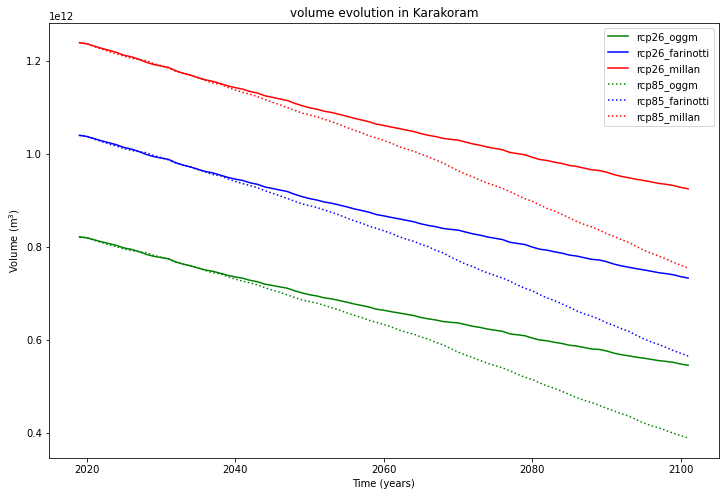

In [121]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']

for k in range(0,4,3):
    for data in data_list:
    
        if (k==0):
            if (data=='farinotti'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif (data=='millan'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif (k==1):
            if (data=='farinotti'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="b")
            elif (data=='millan'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="r")
            else:
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="g")
        elif(k==2):
            if (data=='farinotti'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="b")
            elif (data=='millan'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="r")
            else:
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="g")
        elif(k==3):
            if (data=='farinotti'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="b")
            elif (data=='millan'):
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                out_tot_vol[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="g")
                    
plt.xlabel('Time (years)')
plt.ylabel('Volume ($\mathregular{m^3}$)')
plt.legend()          
plt.title('volume evolution in Karakoram')
name = 'massif_Karakoram_evol_volume_rcp.png'
plt.savefig(name, format = 'png')

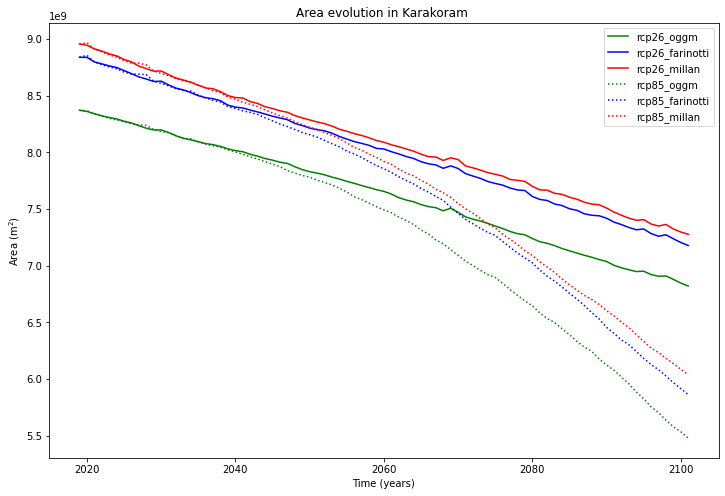

In [123]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']

for k in range(0,4,3):
    for data in data_list:

        if (k==0):
            if (data=='farinotti'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif (data=='millan'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif (k==1):
            if (data=='farinotti'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="b")
            elif (data=='millan'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="r")
            else:
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="g")
        elif(k==2):
            if (data=='farinotti'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="b")
            elif (data=='millan'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="r")
            else:
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="g")
        elif(k==3):
            if (data=='farinotti'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="b")
            elif (data=='millan'):
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                out_tot_area[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="g")

plt.xlabel('Time (years)')
plt.ylabel('Area ($\mathregular{m^2}$)')
plt.legend()          
plt.title('Area evolution in Karakoram ')
name = 'massif_Karakoram_evol_area_rcp.png'
plt.savefig(name, format = 'png')

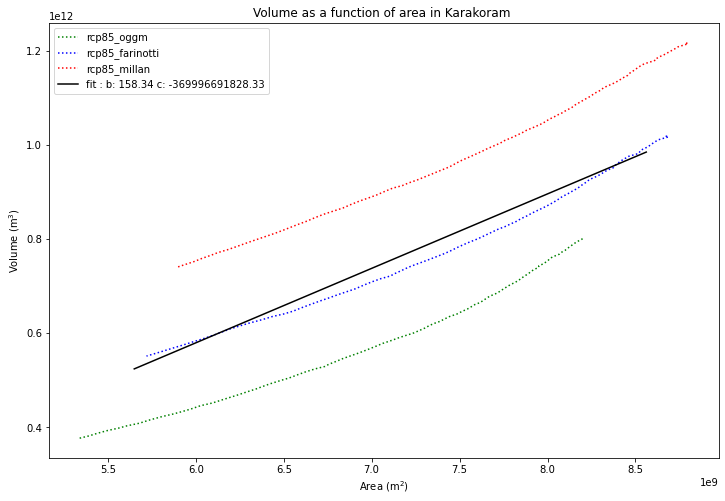

In [90]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']


x_data=[]
y_data=[]
for data in data_list:
    if (data=='farinotti'):
        plt.plot(out_evol[data][3].sum(dim='rgi_id').area,out_evol[data][3].sum(dim='rgi_id').volume,label=''+rcp[3]+'_'+data, linestyle=":",color="b")
    elif (data=='millan'):
        plt.plot(out_evol[data][3].sum(dim='rgi_id').area,out_evol[data][3].sum(dim='rgi_id').volume,label=''+rcp[3]+'_'+data, linestyle=":",color="r")
    else:
        plt.plot(out_evol[data][3].sum(dim='rgi_id').area,out_evol[data][3].sum(dim='rgi_id').volume,label=''+rcp[3]+'_'+data, linestyle=":",color="g")
    x_data.append(out_evol[data][3].sum(dim='rgi_id').area)
    y_data.append(out_evol[data][3].sum(dim='rgi_id').volume)
    
x_data=(x_data[0]+x_data[1]+x_data[2])/3
y_data=(y_data[0]+y_data[1]+y_data[2])/3
               
y_params=np.polyfit(x_data,y_data,1)
y=np.poly1d(y_params)
t = np.linspace(min(x_data), max(x_data), 100)
plt.plot(t, y(t), c="k", label='fit : b: {:.2f}'.format(y_params[0]) + ' c: {:.2f}'.format(y_params[1]))

#y_params2=np.polyfit(x_data,y_data,2)
#y2=np.poly1d(y_params2)
#plt.plot(t, y2(t), c="orange", label='p2: {:.2f}'.format(y_params2[0]) + ' p1: {:.2f}'.format(y_params2[1]))


plt.xlabel('Area ($\mathregular{m^2}$)')
plt.ylabel('Volume ($\mathregular{m^3}$)')
plt.legend()          
plt.title('Volume as a function of area in Karakoram ')
name = 'massif_Karakoram_evol_ratio_rcp.png'
plt.savefig(name, format = 'png')


Text(0.5, 1.0, 'length evolution ')

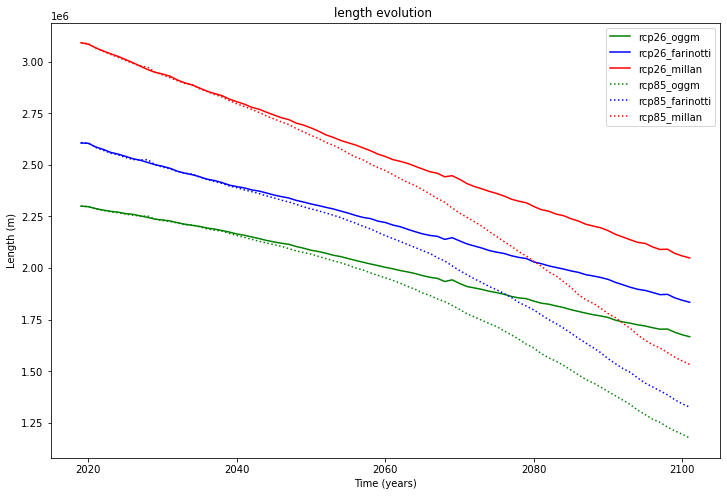

In [124]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']

for k in range(0,4,3):
    for data in data_list:
    
        if (k==0):
            if (data=='farinotti'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif (data=='millan'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif (k==1):
            if (data=='farinotti'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="b")
            elif (data=='millan'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="r")
            else:
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="-.",color="g")
        elif(k==2):
            if (data=='farinotti'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="b")
            elif (data=='millan'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="r")
            else:
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle="--",color="g")
        elif(k==3):
            if (data=='farinotti'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="b")
            elif (data=='millan'):
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                out_tot_length[data][k].plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=":",color="g")
                    
plt.xlabel('Time (years)')
plt.ylabel('Length (m)')
plt.legend()          
plt.title( 'length evolution ')


### Peak water

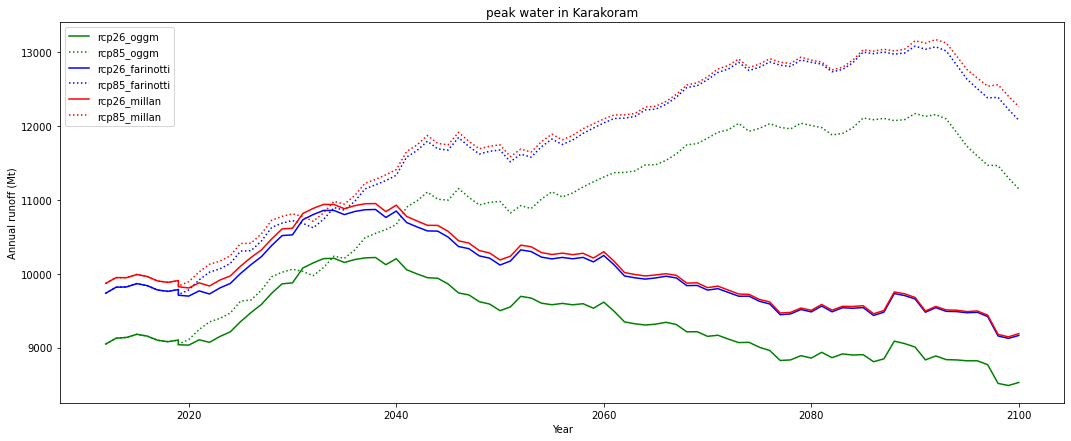

In [92]:
f, ax = plt.subplots(figsize=(18, 7))
rcp=['rcp26','rcp45','rcp60','rcp85']

for data in data_list: #loop all data sources
    for k in range(0,4,3): #loop all scenarios
         # Select annual variables
        d_p=out_evol[data][k]
        d_ptot=d_p.sum(dim='rgi_id')
        
        d_h=out_hydro_hist[data]
        d_htot = d_h.sum(dim='rgi_id')

        sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
        sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
        # And create a dataframe
        dp_annual = d_ptot[sel_vars].to_dataframe()
        dh_annual = d_htot[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.drop([2101],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        if (k==0):
            if (data=='farinotti'):
                dp_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle="-",color="b")
              
            elif(data=='millan'):
                dp_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle="-",color="r")

            else:
                dp_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle="-",color="g")

        elif(k==3):
            if (data=='farinotti'):
                dp_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle=":",color="b")
                #dp_melt.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label='melt_'+rcp[k]+'_'+data, linestyle="-.",color="b")                                                  
            elif(data=='millan'):
                dp_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle=":",color="r")
                #dp_melt.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label='melt_'+rcp[k]+'_'+data, linestyle="-.",color="r")
            else:
                dp_runoff.sum(axis=1).rolling(window=10).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle=":",color="g")
         
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title('peak water in Karakoram')
plt.legend();
name = 'massif_Karakoram_peak_water_hp.png'
plt.savefig(name, format = 'png')

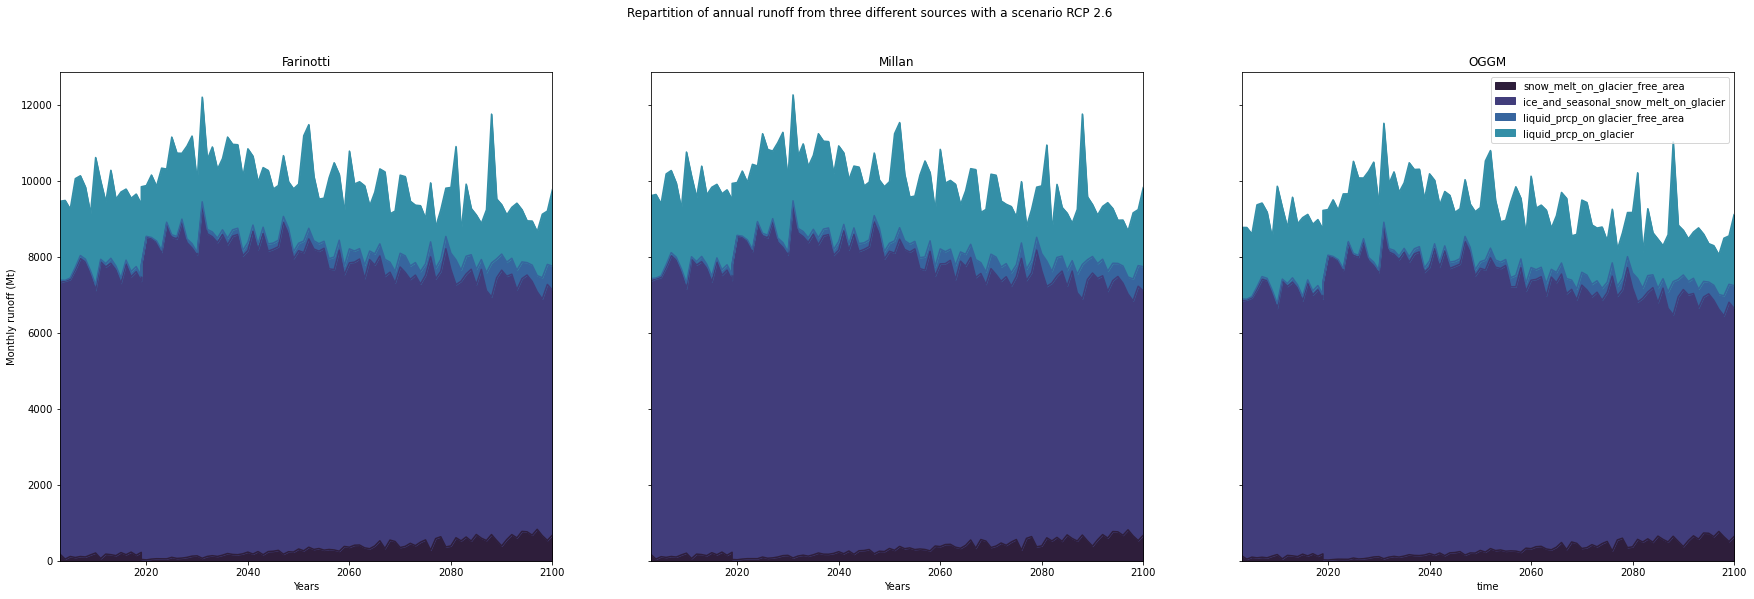

In [93]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30, 9),sharey=True)

for data in data_list: #loop all data sources
    d_p=out_evol[data][0]
    d_ptot=d_p.sum(dim='rgi_id')
        
    d_h=out_hydro_hist[data]
    d_htot = d_h.sum(dim='rgi_id')

    sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
    sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
    # And create a dataframe
    dp_annual = d_ptot[sel_vars].to_dataframe()
    dh_annual = d_htot[sel_vars_hist].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
    dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
    dp_runoff = dp_runoff.drop([2101],axis=0)
        
    dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
    dh_runoff = dh_runoff.drop([2020],axis=0)
        
    dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0) #historical and projections in the same Dataframe
    dp_runoff=dp_runoff.rename(columns={ "melt_off_glacier":"snow_melt_on_glacier_free_area",
                              "melt_on_glacier":"ice_and_seasonal_snow_melt_on_glacier",
                              "liq_prcp_off_glacier":"liquid_prcp_on glacier_free_area",
                              "liq_prcp_on_glacier":"liquid_prcp_on_glacier"})
    
    if (data=='farinotti'):
        dp_runoff.plot.area(ax=ax1, legend=False, title='Farinotti', color=sns.color_palette("mako"));
    elif(data=='millan'):
        dp_runoff.plot.area(ax=ax2, legend=False, title='Millan', color=sns.color_palette("mako")); 
    else:
        dp_runoff.plot.area(ax=ax3, title='OGGM', color=sns.color_palette("mako"));

plt.suptitle('Repartition of annual runoff from three different sources with a scenario RCP 2.6')
ax1.set_ylabel('Monthly runoff (Mt)'); ax2.set_ylabel('Monthly runoff (Mt)'); ax3.set_ylabel('Monthly runoff (Mt)')
ax1.set_xlabel('Years'); ax2.set_xlabel('Years'); ax3.set_ylabel('Years')
ax1.set_xlim(2003,2100);ax2.set_xlim(2003,2100);ax3.set_xlim(2003,2100)
ax1.set_ylim(bottom=0);ax2.set_ylim(bottom=0);ax3.set_ylim(bottom=0)

name = 'Karakoram_distrib_runoff_26.png'
plt.savefig(name, format = 'png')

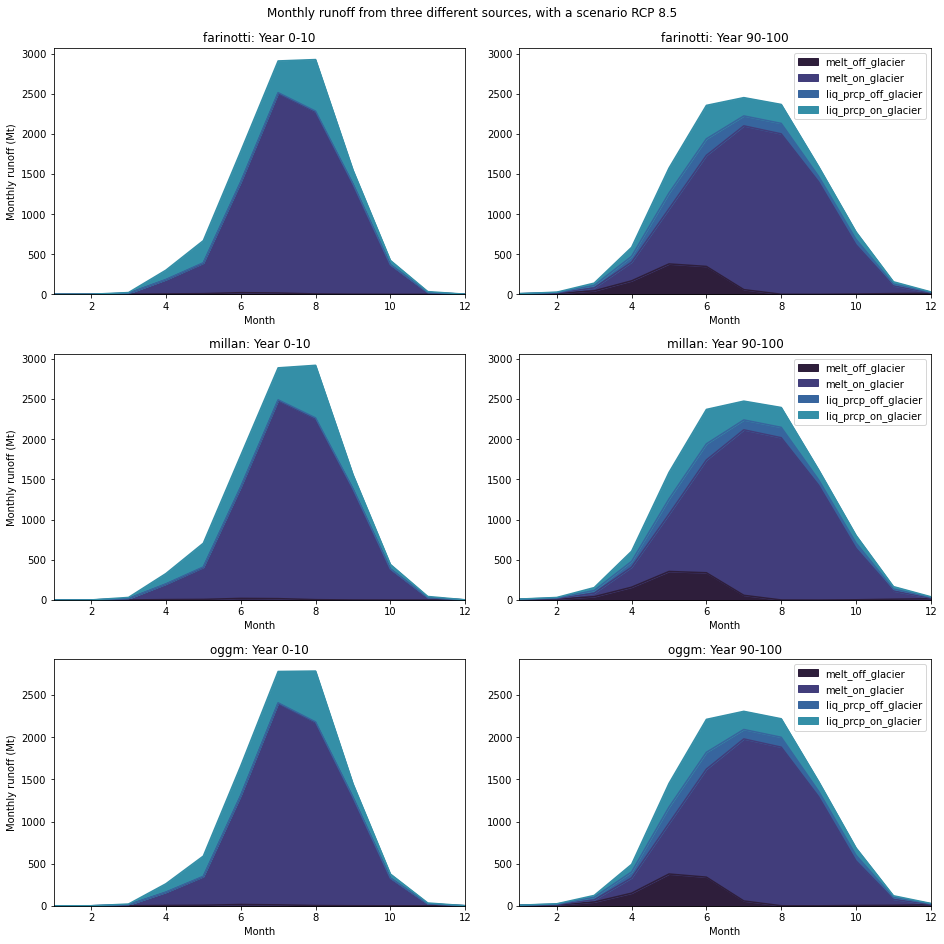

In [94]:
import matplotlib.gridspec as gridspec
fig2 = plt.figure(figsize=(13, 13),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])
f2_ax5 = fig2.add_subplot(spec2[2, 0])
f2_ax6 = fig2.add_subplot(spec2[2, 1])



for data in data_list:
    d_p=out_evol[data][3]
    d_ptot=d_p.sum(dim='rgi_id')


    dp_roll=d_ptot.roll(month_2d=d_ptot['calendar_month_2d'].data[0]-1, roll_coords=True)
    dp_roll['month_2d' ] = dp_roll['calendar_month_2d']


    # Pick the variables we need (the 2d ones)
    sel_vars = [v for v in dp_roll.variables if 'month_2d' in dp_roll[v].dims]


    # Pick the first decade and average it
    df_m_s = dp_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    # Rename the columns for readability
    df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
    # Because of floating point precision sometimes runoff can be slightly below zero, clip
    df_m_s = df_m_s.clip(0)

    # Same for end
    df_m_e = dp_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
    df_m_e = df_m_e.clip(0)
    if (data=='farinotti'):
        axe=f2_ax1
        axe2=f2_ax2
    elif (data=='millan'):
        axe=f2_ax3
        axe2=f2_ax4
    else :
        axe=f2_ax5
        axe2=f2_ax6
    df_m_s[runoff_vars].plot.area(ax=axe, legend=False, title=''+data+': Year 0-10', color=sns.color_palette("mako"));
    df_m_e[runoff_vars].plot.area(ax=axe2, title=''+data+': Year 90-100', color=sns.color_palette("mako"));
    axe.set_ylabel('Monthly runoff (Mt)'); axe.set_xlabel('Month'); axe2.set_xlabel('Month');
    axe.set_xlim(1,12);axe2.set_xlim(1,12)
    a=axe.get_ybound()[1]
    b=axe2.get_ybound()[1]
    mm=max(a,b)
    axe.set_ylim(bottom=0,top=mm);axe2.set_ylim(bottom=0,top=mm)

    
plt.suptitle('Monthly runoff from three different sources, with a scenario RCP 8.5')
name = 'Karakoram_monthly_runoff_85.png'
plt.savefig(name, format = 'png')

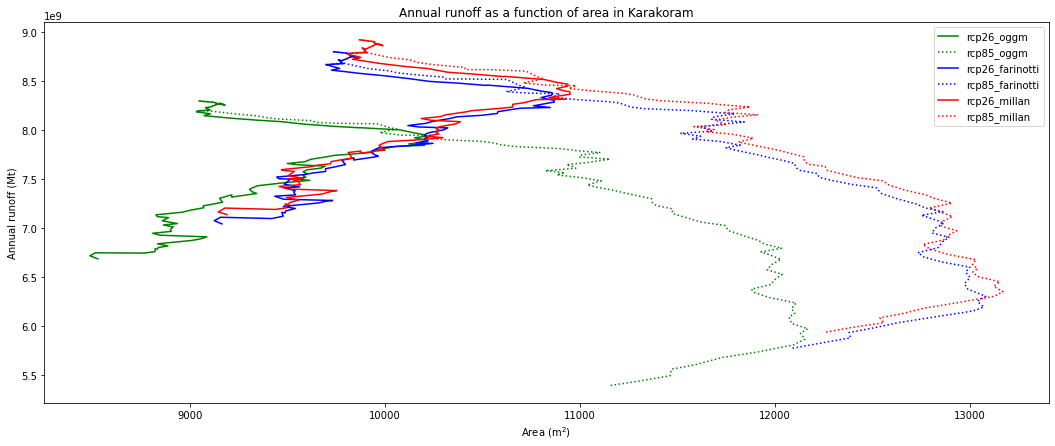

In [95]:
f, ax = plt.subplots(figsize=(18, 7))
rcp=['rcp26','rcp45','rcp60','rcp85']

for data in data_list: #loop all data sources
    for k in range(0,4,3): #loop all scenarios
         # Select annual variables
        d_p=out_evol[data][k]
        d_ptot=d_p.sum(dim='rgi_id')
        
        d_h=out_hydro_hist[data]
        d_htot = d_h.sum(dim='rgi_id')

        sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
        sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
        # And create a dataframe
        dp_annual = d_ptot[sel_vars].to_dataframe()
        dh_annual = d_htot[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.drop([2101],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        dp_area = d_ptot[sel_vars].to_dataframe()
        dh_area = d_htot[sel_vars_hist].to_dataframe()

        dp_area = dp_area['area'].clip(0)
        dp_area = dp_area.drop([2101],axis=0)
        dh_area = dh_area['area'].clip(0)
        dh_area = dh_area.drop([2020],axis=0)
            
        d_area = pd.concat([dh_area,dp_area],axis=0)

        if (k==0):
            if (data=='farinotti'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle="-",color="b")
            elif(data=='millan'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle="-",color="r")
            else:
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle="-",color="g")
        elif(k==3):
            if (data=='farinotti'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle=":",color="b")                          
            elif(data=='millan'):
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle=":",color="r")
            else:
                plt.plot(dp_runoff.sum(axis=1).rolling(window=10).mean(),d_area,label=''+rcp[k]+'_'+data, linestyle=":",color="g")
         
ax.set_ylabel('Annual runoff (Mt)')

plt.xlabel('Area ($\mathregular{m^2}$)')
plt.title('Annual runoff as a function of area in Karakoram')
plt.legend();
name = 'massif_Karakoram_peak_water-area.png'
plt.savefig(name, format = 'png')